<a href="https://colab.research.google.com/github/ReynardAdimas/Asah/blob/main/Reynard_Adimas_Nabil_Template_Submission_Akhir_Klasifikasi_Gambar_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Reynard Adimas Nabil
- **Email:** m297d5y1692@student.devacademy.id
- **ID Dicoding:** M297D5Y1692

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [ ]:
!pip install -q kaggle
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

### Data Preprocessing

In [ ]:
import os
import shutil

train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"
validation_dir = "Vegetable Images/validation"

combined_dir = "Vegetable Images/dataset"

os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(validation_dir):
  category_dir = os.path.join(validation_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

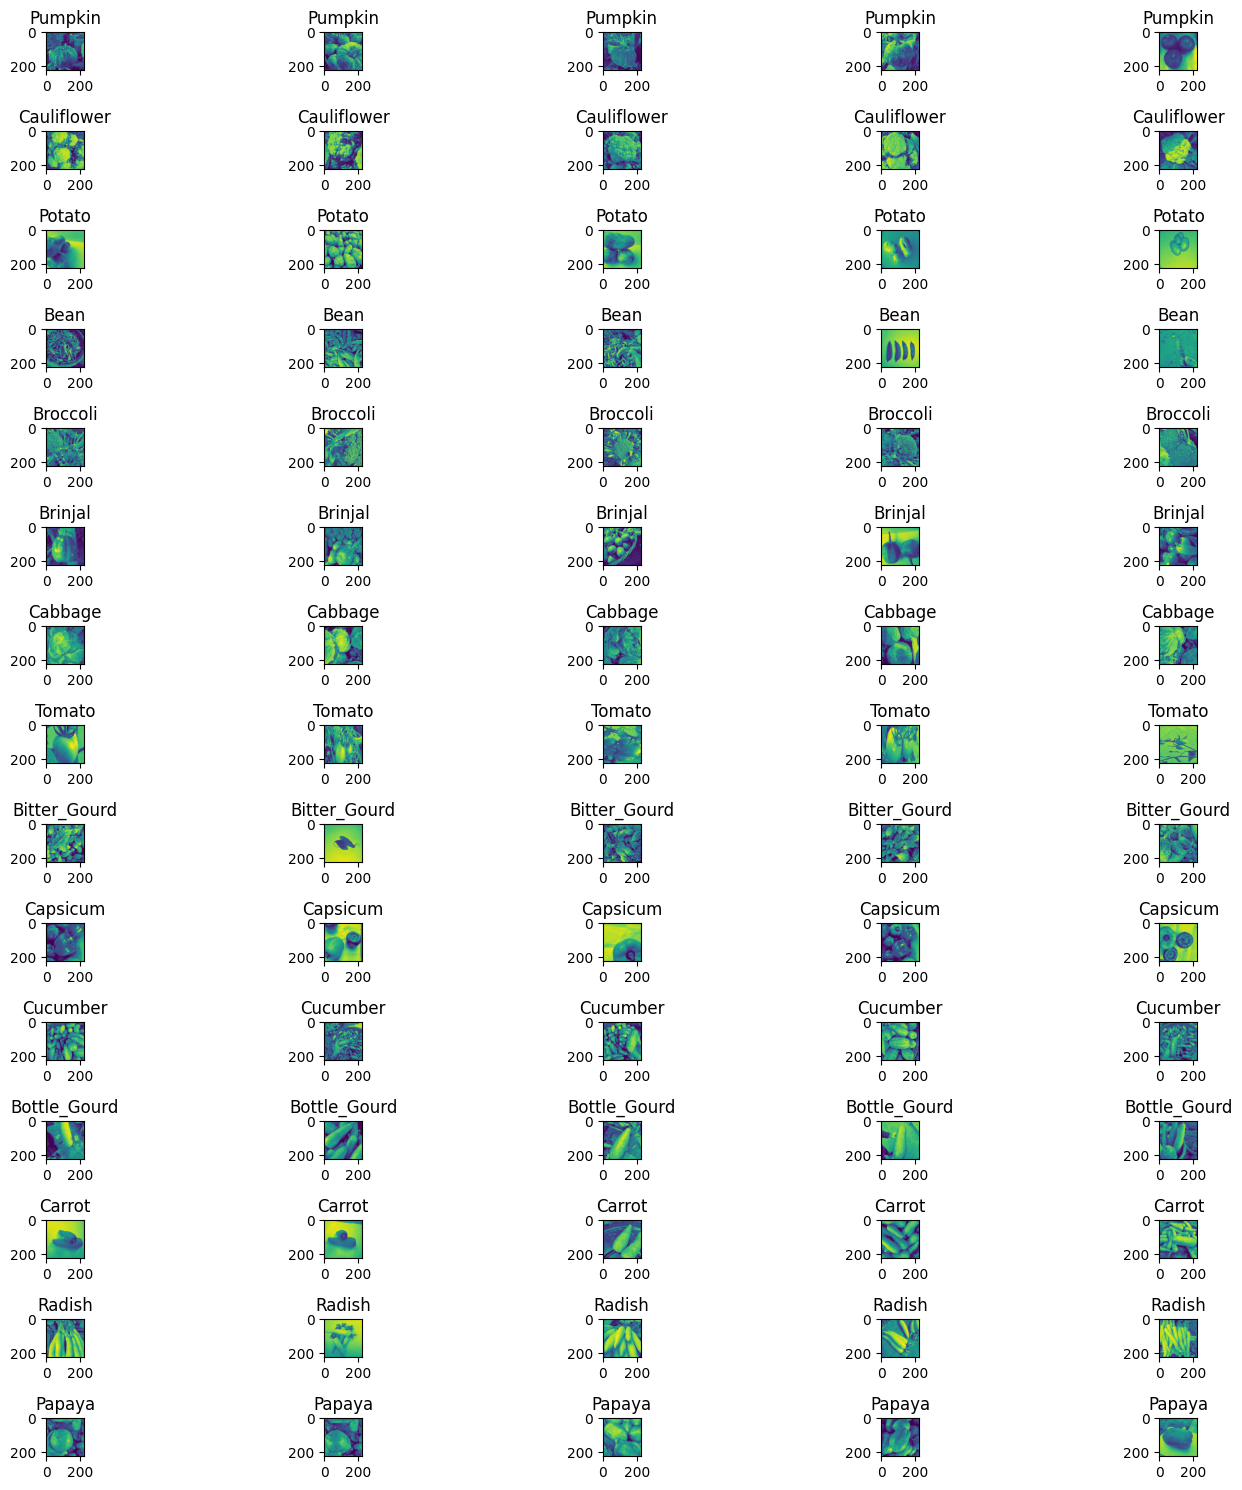

In [ ]:
# Dataset Checking
vegetable_image = {}

path = "Vegetable Images/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  vegetable_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Vegetable Images/dataset/"

fig, axes = plt.subplots(len(vegetable_image.keys()), 5, figsize=(15,15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(vegetable_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axes[i, j].imshow(img)
    axes[i, j].set_title(class_name)



fig.tight_layout()

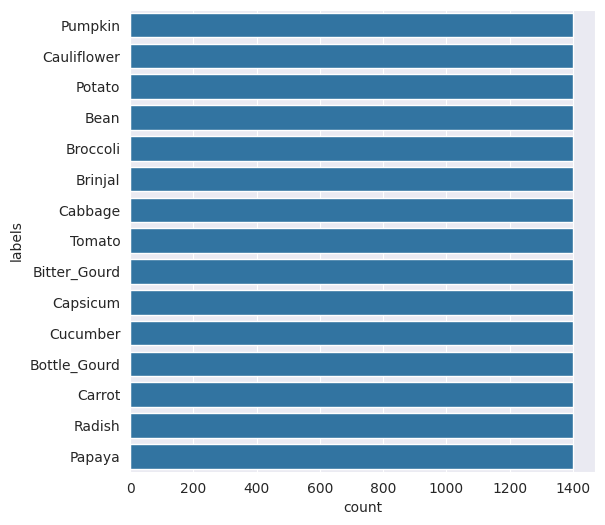

In [ ]:
# Plot Distribusi
vegetable_path = "Vegetable Images/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(vegetable_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    k_size = random.choice([3,5,7])
    img = cv2.GaussianBlur(img, (k_size, k_size), 0)
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Vegetable Images/dataset/"
augmented_path = "Vegetable Images/augmented/"

if not os.path.exists(augmented_path):
  os.makedirs(augmented_path)

# The variable 'images' is not defined. It seems you intended to get a list of all image paths from the dataset.
# I will add a line to collect all image paths from 'images_path' into the 'images' list.
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total Image: {len(images)}")

i = 1
images_to_generate = 2500
while i<= images_to_generate:
  image_path_select = random.choice(images)

  try:
    class_name = os.path.basename(os.path.dirname(image_path_select)) # Corrected to get class name from directory
    original_image = io.imread(image_path_select)

    if original_image.ndim < 3:
      continue

    transformed_image = original_image.copy()
    transformation_count = random.randint(1, len(transformations))

    n = 0
    while n < transformation_count:
      key = random.choice(list(transformations))

      transformed_image = transformations[key](transformed_image)
      n = n+1

    save_path = os.path.join(augmented_path, class_name)
    if not os.path.exists(save_path):
      os.makedirs(save_path)

    # Convert float image to uint8 for cv2.imwrite
    transformed_image = img_as_ubyte(transformed_image)
    # Check if the image is grayscale or color before converting
    if transformed_image.ndim == 3 and transformed_image.shape[-1] == 3:
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
    elif transformed_image.ndim == 2:
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_GRAY2BGR)

    new_image_name = f"aug_{i}.jpg"
    new_image_path = os.path.join(save_path, new_image_name)

    cv2.imwrite(new_image_path, transformed_image)

    if i%100 == 0:
      print(f"Berhasil generate {i} gambar")

    i = i+1
  except Exception as e:
    print(f"Error: {e}")


Streaming output truncated to the last 5000 lines.
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function '

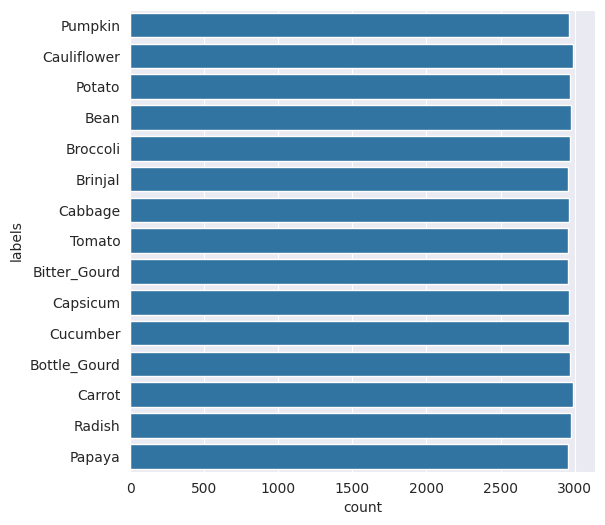

In [ ]:
img_path = "Vegetable Images/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(img_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, "file_name" : file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [ ]:
mypath = "Vegetable Images/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})
df.groupby(['labels']).size()



,0
labels,
Bean,2974
Bitter_Gourd,2952
Bottle_Gourd,2968
Brinjal,2953
Broccoli,2971
Cabbage,2963
Capsicum,2963
Carrot,2989
Cauliflower,2988


In [ ]:
X = df['path']
y = df['labels']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=420)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=420)

In [ ]:
df_tr = pd.DataFrame({"path":X_train, "labels":y_train, "set" : "train"})
df_val = pd.DataFrame({"path":X_val, "labels":y_val, "set" : "validation"})
df_test = pd.DataFrame({"path":X_test, "labels":y_test, "set" : "test"})

print('train size', len(df_tr))
print('validation size', len(df_val))
print('test size', len(df_test))

train size 35600
validation size 4450
test size 4450


In [ ]:
df_all = pd.concat([df_tr, df_val, df_test], ignore_index=True)

print(df_all.groupby(['set','labels']).size(),'\n')

print(df_all.sample(5))

set         labels      
test        Bean             316
            Bitter_Gourd     271
            Bottle_Gourd     289
            Brinjal          323
            Broccoli         284
            Cabbage          324
            Capsicum         280
            Carrot           306
            Cauliflower      318
            Cucumber         262
            Papaya           282
            Potato           303
            Pumpkin          324
            Radish           280
            Tomato           288
train       Bean            2356
            Bitter_Gourd    2368
            Bottle_Gourd    2386
            Brinjal         2351
            Broccoli        2392
            Cabbage         2359
            Capsicum        2391
            Carrot          2387
            Cauliflower     2371
            Cucumber        2407
            Papaya          2389
            Potato          2353
            Pumpkin         2330
            Radish          2414
            Tomato

In [ ]:
from tqdm.notebook import tqdm

df_all = pd.concat([df_tr, df_val, df_test], ignore_index=True)

dataset_final_path = "Dataset-Final"

for index, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):
  src = row['path']
  label_name = row['labels']
  split_type = row['set']
  dest_dir = os.path.join(dataset_final_path, split_type, label_name)
  if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

  file_name = os.path.basename(src)
  dest = os.path.join(dest_dir, file_name)

  if os.path.exists(src):
    if not os.path.exists(dest):
      shutil.copy2(src, dest)
  else:
    print(f"File tidak ditemukan di {src}")

print("\nProses penyalinan selesai")

  0%|          | 0/44500 [00:00<?, ?it/s]


Proses penyalinan selesai


##Image Data Generator

In [ ]:
import os

base_dir = "Dataset-Final"
TRAIN_DIR = os.path.join(base_dir, 'train')
VAL_DIR = os.path.join(base_dir, 'validation')
TEST_DIR = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 22112 images belonging to 15 classes.
Found 4234 images belonging to 15 classes.
Found 4231 images belonging to 15 classes.


## Modelling

In [ ]:
num_classes = train_generator.num_classes

model_1 = Sequential()

model_1.add(Conv2D(32, (3,3),activation='relu', input_shape=(128,128,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))

model_1.add(Conv2D(64, (3, 3),activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_classes, activation='softmax'))
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print(model_1.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,471 (12.62 MB)

 Trainable params: 3,307,023 (12.62 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [ ]:
from sklearn.utils import class_weight

train_labels = train_generator.classes
unique_classes = np.unique(train_labels)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_labels
)

class_weights_dict = dict(zip(unique_classes, class_weights))
print(f"Class Weight:{class_weights_dict}")

history_1 = model_1.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Class Weight:{np.int32(0): np.float64(0.999412429378531), np.int32(1): np.float64(1.0034944406625823), np.int32(2): np.float64(0.992682379349046), np.int32(3): np.float64(1.0138468592388812), np.int32(4): np.float64(1.0000904568068747), np.int32(5): np.float64(1.00281179138322), np.int32(6): np.float64(1.0014492753623188), np.int32(7): np.float64(0.9853832442067736), np.int32(8): np.float64(0.99134723156243), np.int32(9): np.float64(0.9973838520523229), np.int32(10): np.float64(0.999412429378531), np.int32(11): np.float64(1.0041780199818346), np.int32(12): np.float64(1.0082991336069311), np.int32(13): np.float64(0.9900156704723528), np.int32(14): np.float64(1.0110653863740284)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 120s 162ms/step - accuracy: 0.3460 - loss: 2.3820 - val_accuracy: 0.4962 - val_loss: 1.6644
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 111s 160ms/step - accuracy: 0.5882 - loss: 1.2379 - val_accuracy: 0.6620 - val_loss: 1.1873
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 112s 163ms/step - accuracy: 0.6856 - loss: 0.9502 - val_accuracy: 0.7100 - val_loss: 0.9128
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 111s 161ms/step - accuracy: 0.7662 - loss: 0.7108 - val_accuracy: 0.8599 - val_loss: 0.4351
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 110s 159ms/step - accuracy: 0.8150 - loss: 0.5881 - val_accuracy: 0.5994 - val_loss: 3.4698
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - accuracy: 0.8445 - loss: 0.4961 - val_accuracy: 0.7447 - val_loss: 1.1437
Epoch 7/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 110s 160ms/step - accuracy: 0.8728 - loss: 0.4140 - val_accuracy: 0.7964 - val_loss: 1.0200
Epoch 8/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 111s 161ms/step - accuracy: 0.8894 -

In [ ]:
num_classes = train_generator.num_classes

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3),activation='relu', input_shape=(128,128,3)))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2)))

model_2.add(Conv2D(64, (3, 3),activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2, 2)))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2, 2)))

model_2.add(Flatten())
model_2.add(Dense(128, activation = 'relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(num_classes, activation='softmax'))
model_2.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print(model_1.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,921,519 (37.85 MB)

 Trainable params: 3,307,023 (12.62 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,614,048 (25.23 MB)

None


In [ ]:
from sklearn.utils import class_weight

train_labels = train_generator.classes
unique_classes = np.unique(train_labels)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_labels
)

class_weights_dict = dict(zip(unique_classes, class_weights))
print(f"Class Weight:{class_weights_dict}")

history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    verbose=1
)

Class Weight:{np.int32(0): np.float64(0.999412429378531), np.int32(1): np.float64(1.0034944406625823), np.int32(2): np.float64(0.992682379349046), np.int32(3): np.float64(1.0138468592388812), np.int32(4): np.float64(1.0000904568068747), np.int32(5): np.float64(1.00281179138322), np.int32(6): np.float64(1.0014492753623188), np.int32(7): np.float64(0.9853832442067736), np.int32(8): np.float64(0.99134723156243), np.int32(9): np.float64(0.9973838520523229), np.int32(10): np.float64(0.999412429378531), np.int32(11): np.float64(1.0041780199818346), np.int32(12): np.float64(1.0082991336069311), np.int32(13): np.float64(0.9900156704723528), np.int32(14): np.float64(1.0110653863740284)}
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 131s 182ms/step - accuracy: 0.5249 - loss: 1.5826 - val_accuracy: 0.8621 - val_loss: 0.4200
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 132s 191ms/step - accuracy: 0.8087 - loss: 0.6020 - val_accuracy: 0.8658 - val_loss: 0.4052
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 119s 158m

## Evaluasi dan Visualisasi

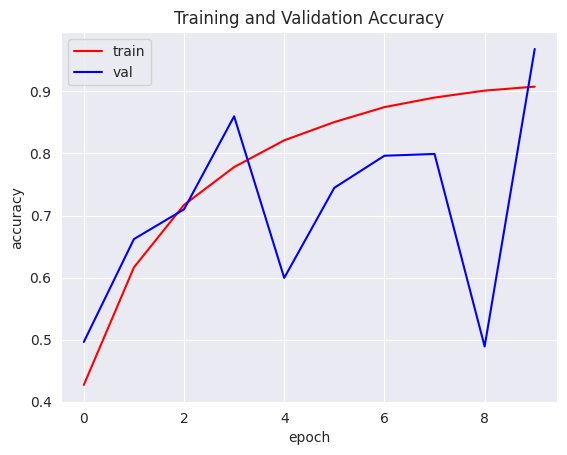

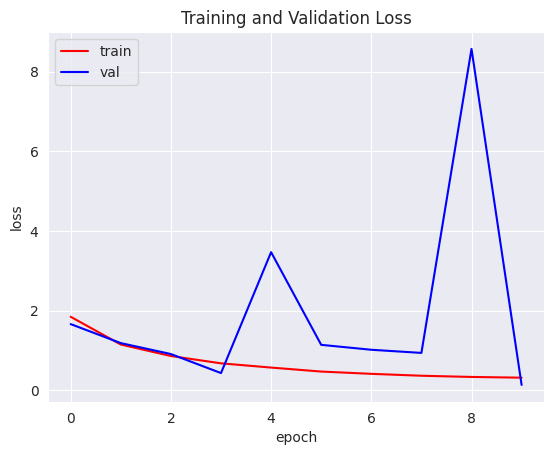

In [ ]:
acc = history_1.history['accuracy']
vall_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, vall_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

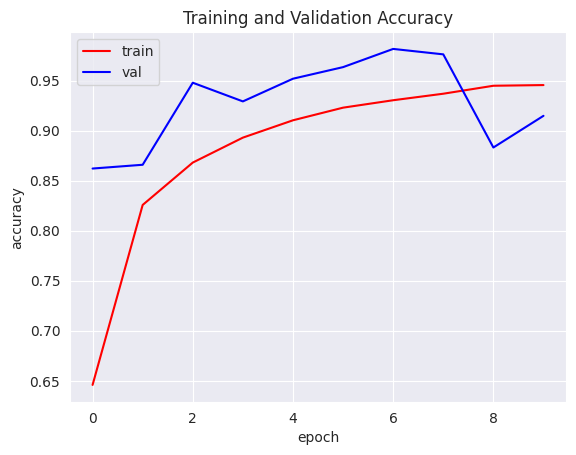

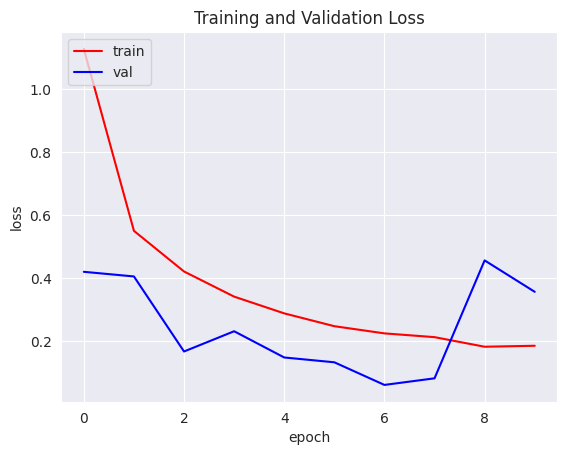

In [ ]:
acc = history_2.history['accuracy']
vall_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, vall_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [ ]:
model_2.save("model.h5")

###Konversi ke TFJS

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


2025-12-02 12:35:14.552878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764678914.585709   26693 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764678914.595686   26693 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764678914.621290   26693 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764678914.621326   26693 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764678914.621334   26693 computation_placer.cc:177] computation placer alr

###Konversi ke SavedModel

In [ ]:
export_dir = 'saved_model/1'
model_2.export(export_dir)

Saved artifact at 'saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  136942615095504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941952888144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665452688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665459792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941952887184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665462672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665461520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665459408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665461136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665455184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369416654619

###Konversi ke TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegetable.tflite')
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmpldcx86lj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  136942615095504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941952888144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665452688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665459792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941952887184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665462672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665461520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665459408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665461136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136941665455184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1369416654

13234012

In [ ]:
from google.colab import files
!zip -r /content/backup_semua_file.zip /content -x "/content/sample_data/*" "/content/.config/*"
files.download("/content/backup_semua_file.zip")

Streaming output truncated to the last 5000 lines.
updating: content/Dataset-Final/train/Bottle_Gourd/0038.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/1152.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/0510.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/0468.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/aug_1359.jpg (deflated 1%)
updating: content/Dataset-Final/train/Bottle_Gourd/0345.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/0086.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/1166.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/0447.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/aug_820.jpg (deflated 2%)
updating: content/Dataset-Final/train/Bottle_Gourd/0658.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/0313.jpg (deflated 0%)
updating: content/Dataset-Final/train/Bottle_Gourd/077

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)